# Learned Amino Acid Embeddings

In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf

from pepdata import amino_acid_properties as aap

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

from ionmob.preprocess.helpers import tokenizer_from_json
from ionmob.preprocess.data import to_tf_dataset, to_tf_dataset_inference

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
def plot_dendrogram(model, **kwargs):
    plt.figure(figsize=(10, 6), dpi=200)
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [5]:
data = pd.read_parquet('../data/Meier.parquet')
GRUPredictor = tf.keras.models.load_model('../pretrained-models/GRUPredictor/')
tokenizer = tokenizer_from_json('../pretrained-models/tokenizers/tokenizer.json')

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

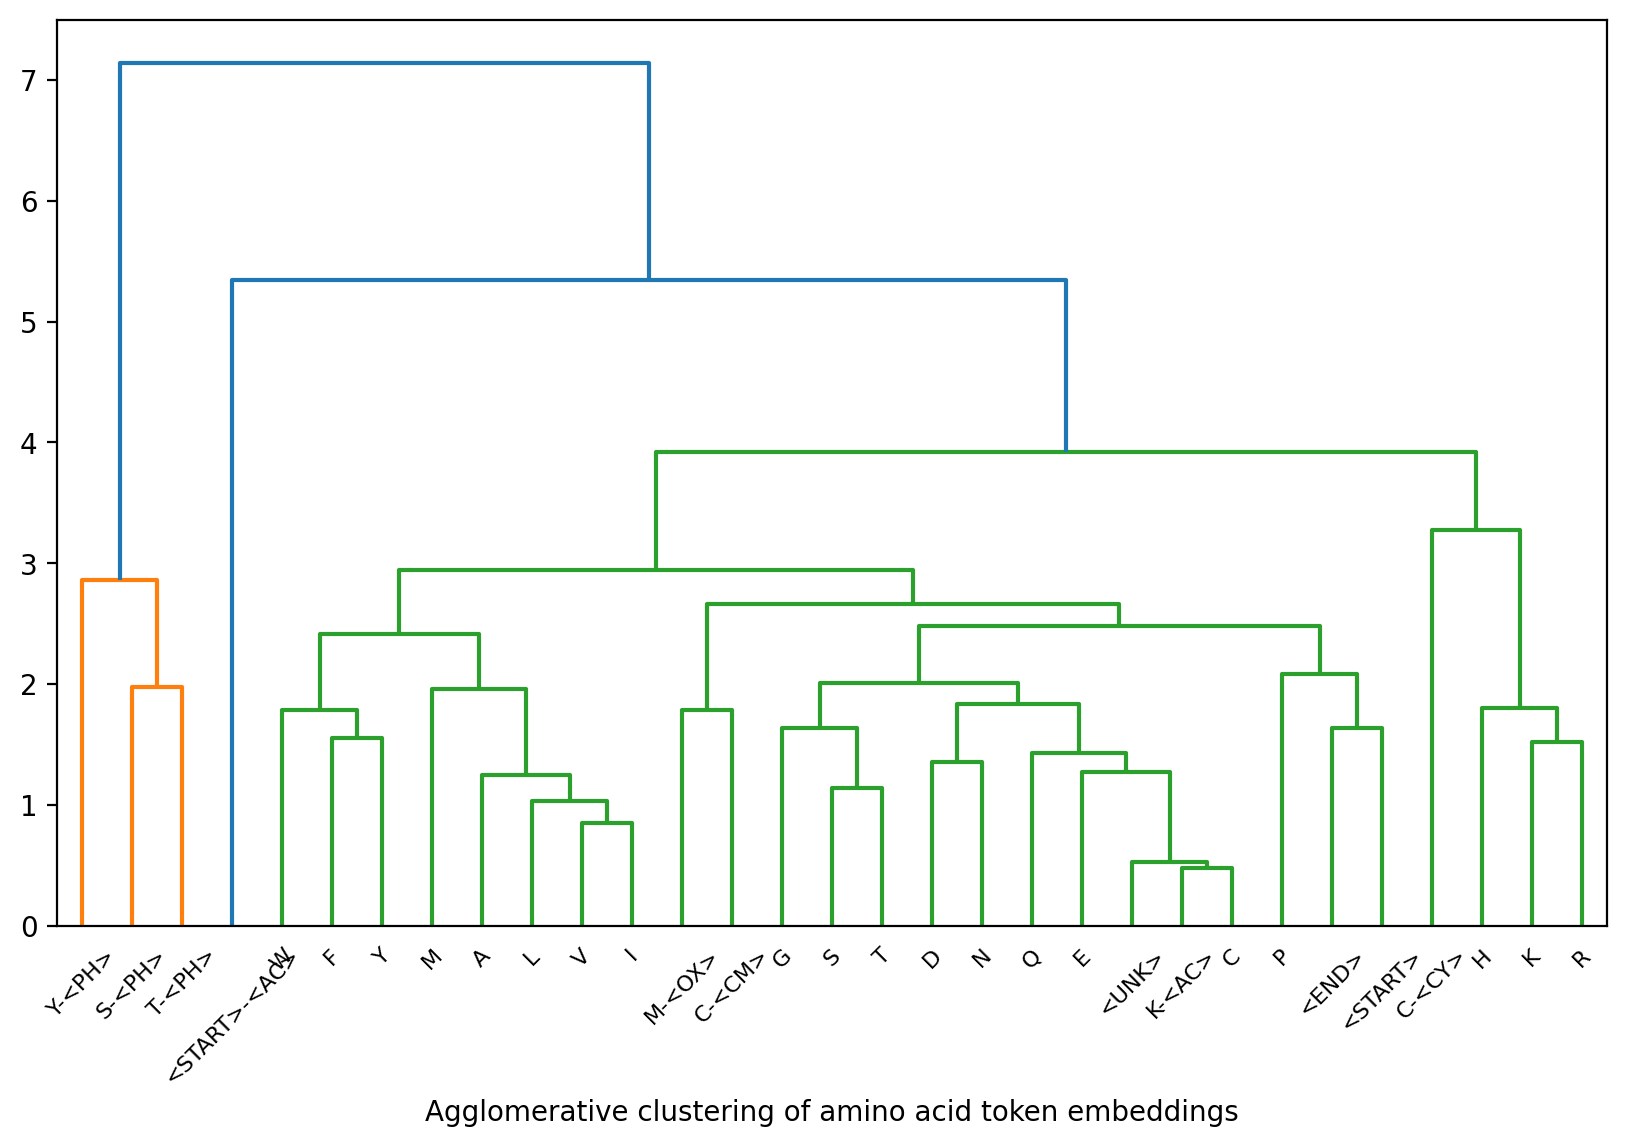

In [7]:
EW = GRUPredictor.layers[1].weights[0].numpy()
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(EW)

plot_dendrogram(model, truncate_mode="level", p=200, labels=['<UNK>'] + list(tokenizer.word_index.keys()))
plt.xlabel("Agglomerative clustering of amino acid token embeddings")
plt.show()

# Correlation of Deep Prediction with additive AA Properties

In [9]:
MODS = set(['<START>-<AC>', 'T-<PH>', 'S-<PH>', 'Y-<PH>', 'K-<AC>', 'M-<OX>', 'C-<CY>'])

NON_CANONICAL = {'<END>': '', '<START>': '', '<START>-<AC>': '', 
                'T-<PH>': 'T', 'S-<PH>': 'S', 'Y-<PH>': 'Y',
                'K-<AC>': 'K', 
                'M-<OX>': 'M',
                'C-<CM>': 'C','C-<CY>': 'C'}

def seq_tokens_to_string(seq):
    l = []
    for char in seq:
        if char in NON_CANONICAL:
            l.append(NON_CANONICAL[char])
        else:
            l.append(char)
            
    return ''.join(l)


def is_unmodified(seq):
    for char in seq:
        if char in MODS:
            return False
    return True

def apply_aa_dict(seq, mz, d):
    s = 0
    for char in seq:
        s += d[char]
        
    return s / len(seq)

model = GRUPredictor

data = pd.read_parquet('../data/synthetic.parquet')
data = data[data.apply(lambda r: is_unmodified(r['sequence-tokenized']), axis=1)]

data['sequence'] = data.apply(lambda r: seq_tokens_to_string(r['sequence-tokenized']), axis=1)

data['volume'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.volume), axis=1)
data['hydropathy'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.hydropathy), axis=1)
data['hydrophilicity'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.hydrophilicity), axis=1)

data['polarity'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.polarity), axis=1)
data['solvent-exposed-area'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.solvent_exposed_area), axis=1)
data['pK-side-chain'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.pK_side_chain), axis=1)

data['accessible-surface-area'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.accessible_surface_area), axis=1)
data['accessible-surface-area-folded'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.accessible_surface_area_folded), axis=1)
data['local-flexibility'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.local_flexibility), axis=1)

data['refractivity'] = data.apply(lambda r: apply_aa_dict(r['sequence'], r['mz'], aap.refractivity), axis=1)

In [10]:
tf_ds = to_tf_dataset_inference(data.mz.values, 
                   data.charge.values, 
                   [list(s) for s in data['sequence-tokenized'].values],
                   #data.ccs,
                   tokenizer, batch=False).batch(2048)

ccs_predicted, deep = model.predict(tf_ds)

data['ccs_predicted'] = ccs_predicted
data['deep'] = np.squeeze(deep) / np.array([mz for mz in data.mz])

387/387 [==============================] - 27s 68ms/step


NameError: name 'create_2d_hist' is not defined

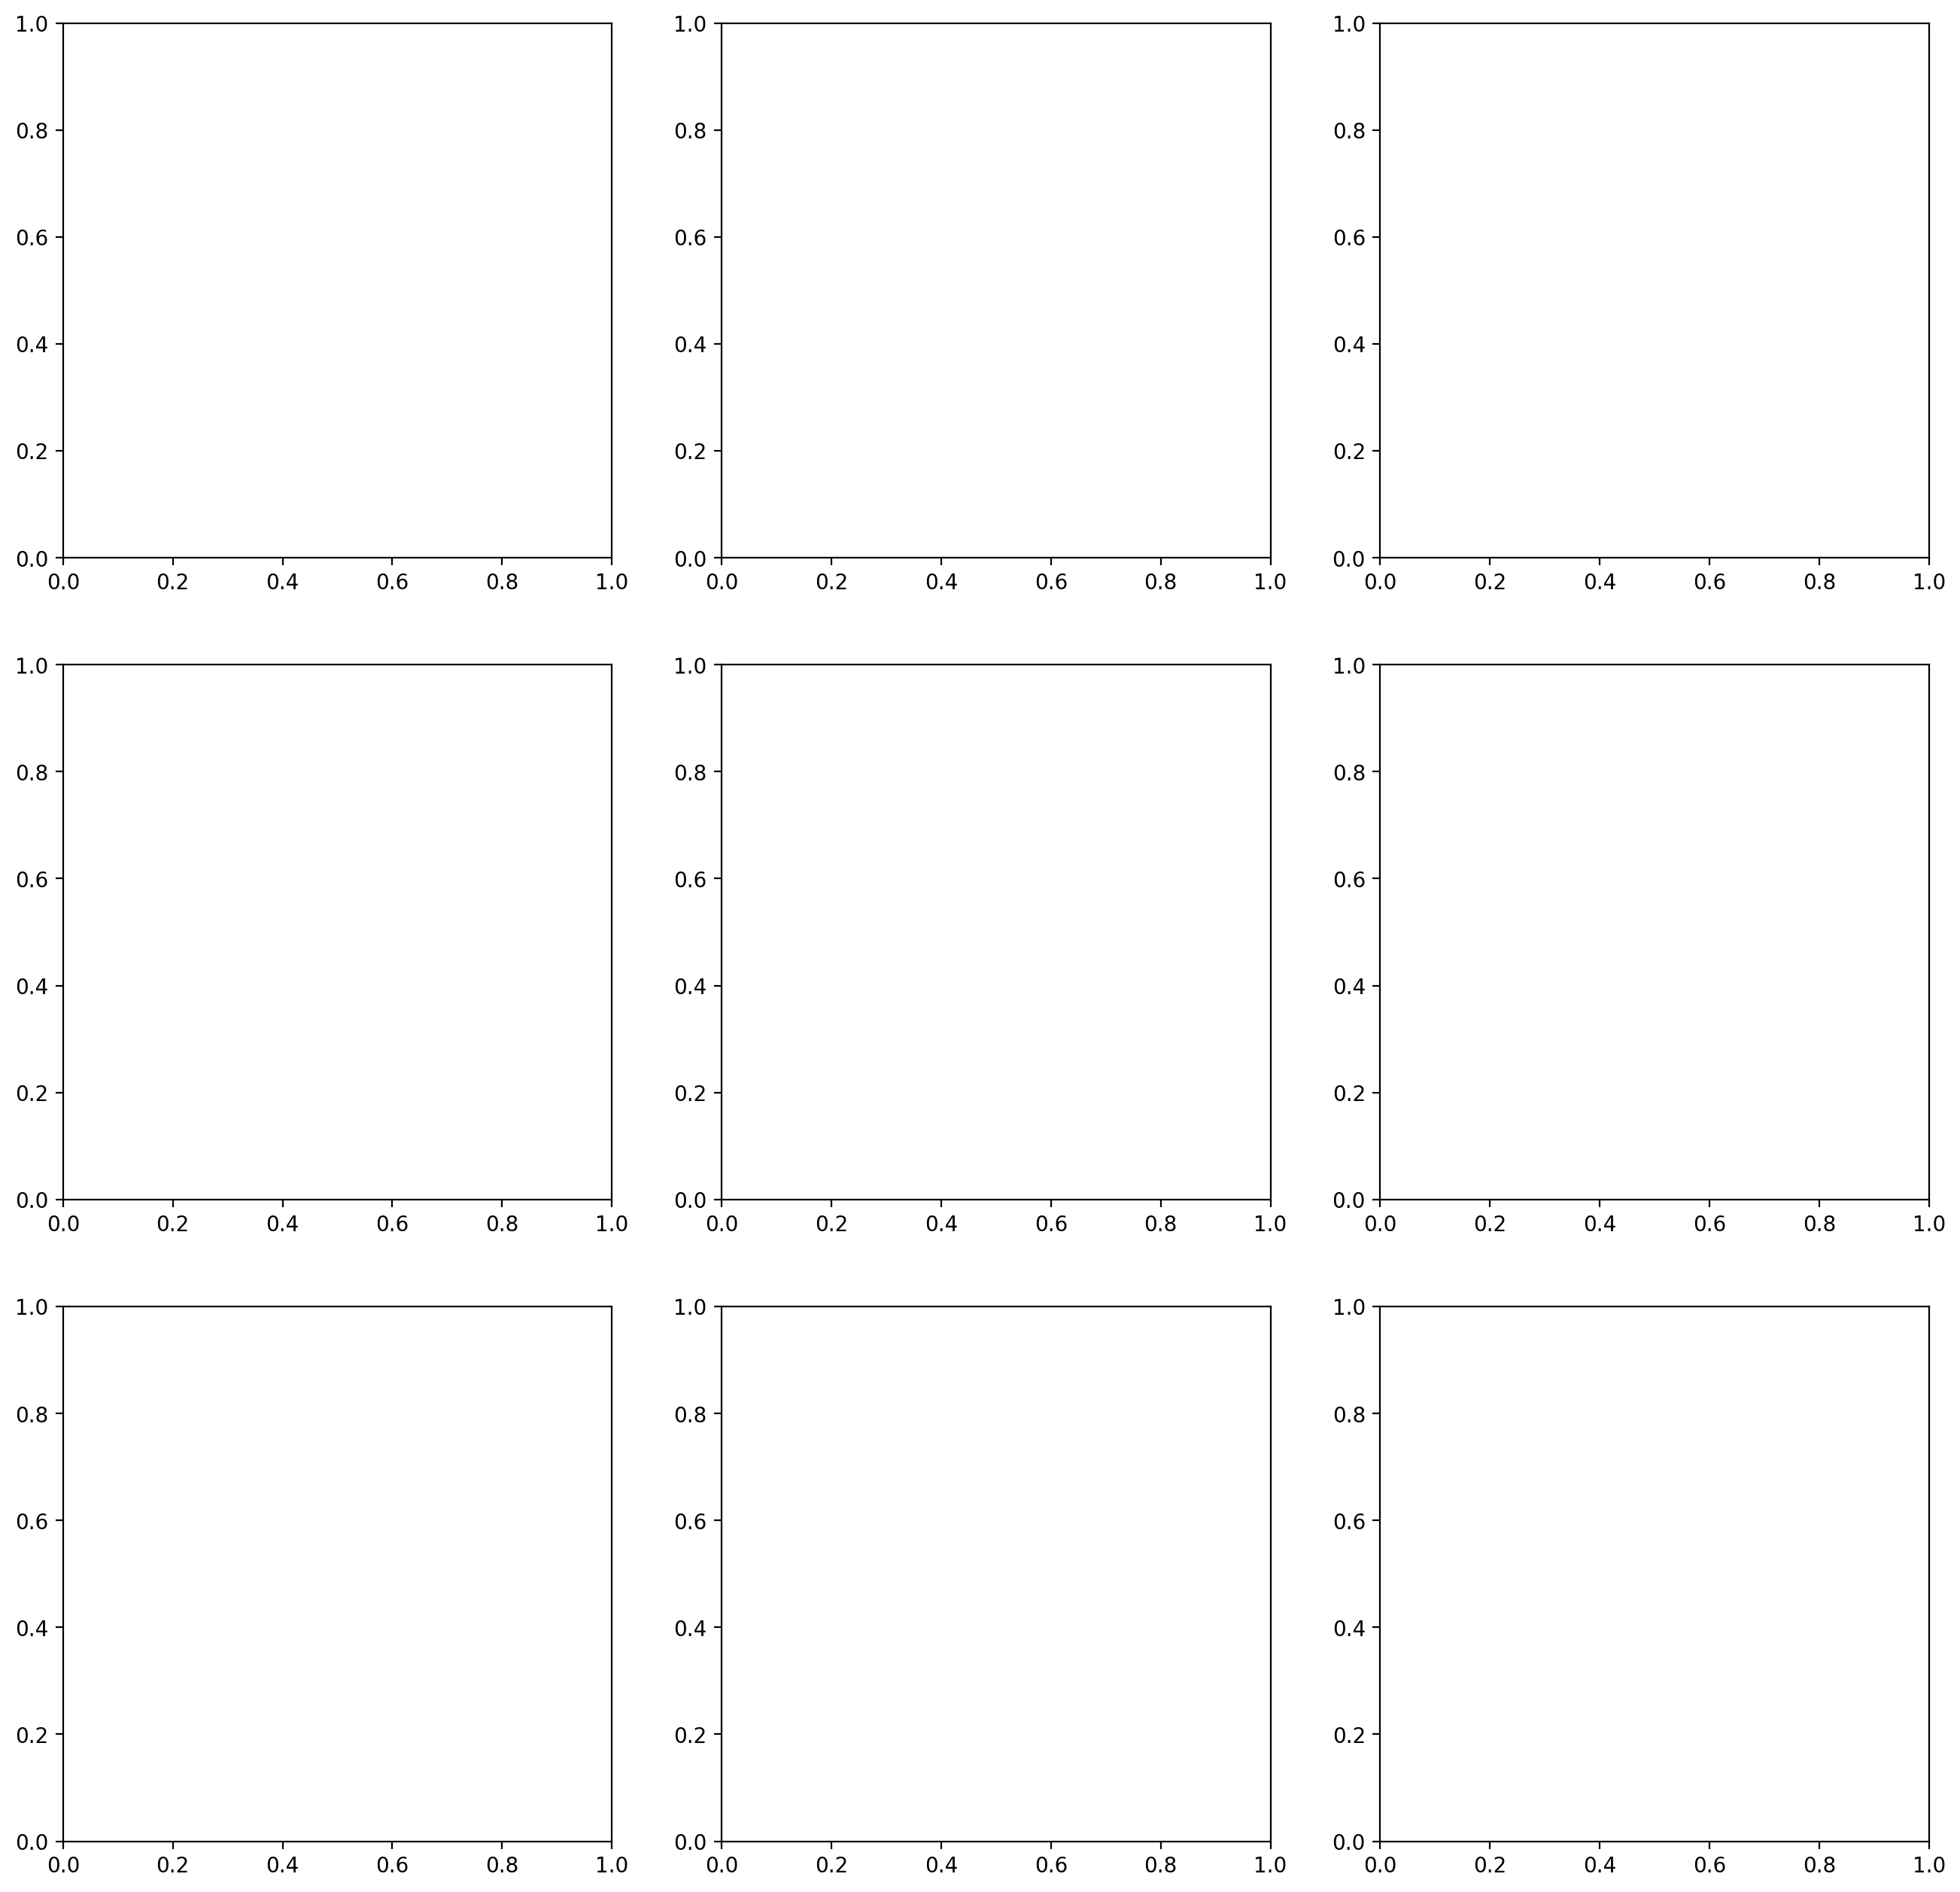

In [11]:
fig, ax_grid = plt.subplots(nrows=3, ncols=3, figsize=(16,16), dpi=200)

for i, prop in enumerate(['volume', 'polarity', 'hydropathy', 'hydrophilicity', 'solvent-exposed-area',
             'accessible-surface-area','accessible-surface-area-folded','local-flexibility'
             ,'pK-side-chain']):
    
    data_tmp = data[data.charge==2]
    prop_tmp = data_tmp[['deep', f'{prop}']]
    
    X = data_tmp[['deep', f'{prop}']].iloc[:, 0].to_numpy()
    Y = data_tmp[['deep', f'{prop}']].iloc[:, 1].to_numpy()
    
    
    
    row = int(np.floor(i / 3))
    col = i % 3
    
    subplot = ax_grid[row][col]
    
    hist, extent = create_2d_hist(prop_tmp, bins=120)
    subplot.imshow(hist, origin="lower", aspect="auto", extent=extent[0]+extent[1], cmap='inferno')
    # subplot.scatter(X, Y, s=10, alpha=0.1)
    if col == 0:
        subplot.set_ylabel('Summed property value')
    if row == 2:
        subplot.set_xlabel('Relative CCS impact')
        
    subplot.set_title(f'{prop}, pearson-r: {np.round(pearsonr(X, Y)[0],2)}')
    
plt.show()

# Phosphorylation Impact learned by Deep Model

In [14]:
def can_be_mod(seq):
    CAN_BE_MOD = set(['S', 'T', 'Y'])
    
    if len(CAN_BE_MOD.intersection(set(seq))) > 0:
        return True
    return False

def get_random_mod_index(seq):
    CAN_BE_MOD = set(['S', 'T', 'Y'])
    
    r_list = []
    for i, item in enumerate(seq):
        if item in CAN_BE_MOD:
            r_list.append(i)
            
    return np.random.choice(r_list)

def randomly_modify_sequence(seq):
    TRANSLATION_DICT = {'S':'S-<PH>', 'T':'S-<PH>', 'Y':'Y-<PH>'}
    index = get_random_mod_index(seq)
    return np.array([*seq[:index], TRANSLATION_DICT[seq[index]], *seq[index + 1:]])

In [13]:
data = data[data.apply(lambda r: can_be_mod(r['sequence-tokenized']), axis=1)]

In [15]:
mod_list, mo_list = [], []

for index, row in data.iterrows():
    mod_list.append(randomly_modify_sequence(row['sequence-tokenized']))
    r = row['sequence-tokenized']
    mo_list.append(['<START>-<AC>',*r[1:]])
    
data['sequence-phos'] = mod_list
data['sequence-acet'] = mo_list

In [16]:
data = data[data.apply(lambda r: can_be_mod(r['sequence-phos']), axis=1)]

In [17]:
mod_list, mo_list = [], []

for index, row in data.iterrows():
    mod_list.append(randomly_modify_sequence(row['sequence-phos']))
    
data['sequence-phos-twice'] = mod_list

In [18]:
tf_ds = to_tf_dataset_inference(data.mz, data.charge, [list(s) for s in data['sequence-tokenized']], 
                      tokenizer=tokenizer)

tf_ds = tf_ds.prefetch(5)

ccs, deep = GRUPredictor.predict(tf_ds)

data['ccs'] = ccs

tf_ds = to_tf_dataset_inference(data.mz, data.charge, [list(s) for s in data['sequence-phos']], 
                      tokenizer=tokenizer)

tf_ds = tf_ds.prefetch(5)

ccs, deep = GRUPredictor.predict(tf_ds)

data['ccs-phos'] = ccs

tf_ds = to_tf_dataset_inference(data.mz, data.charge, [list(s) for s in data['sequence-phos-twice']], 
                      tokenizer=tokenizer)

tf_ds = tf_ds.prefetch(5)

ccs, deep = GRUPredictor.predict(tf_ds)

data['ccs-phos-twice'] = ccs

233/233 [==============================] - 15s 63ms/step


In [19]:
data['ccs_diff'] = np.round(((data.ccs - data['ccs-phos']) / data.ccs) * 100, 2)
data['ccs_diff_phos_twice'] = np.round(((data.ccs - data['ccs-phos-twice']) / data.ccs) * 100, 2)

1.7
2.09
1.31
3.07
4.03
2.75


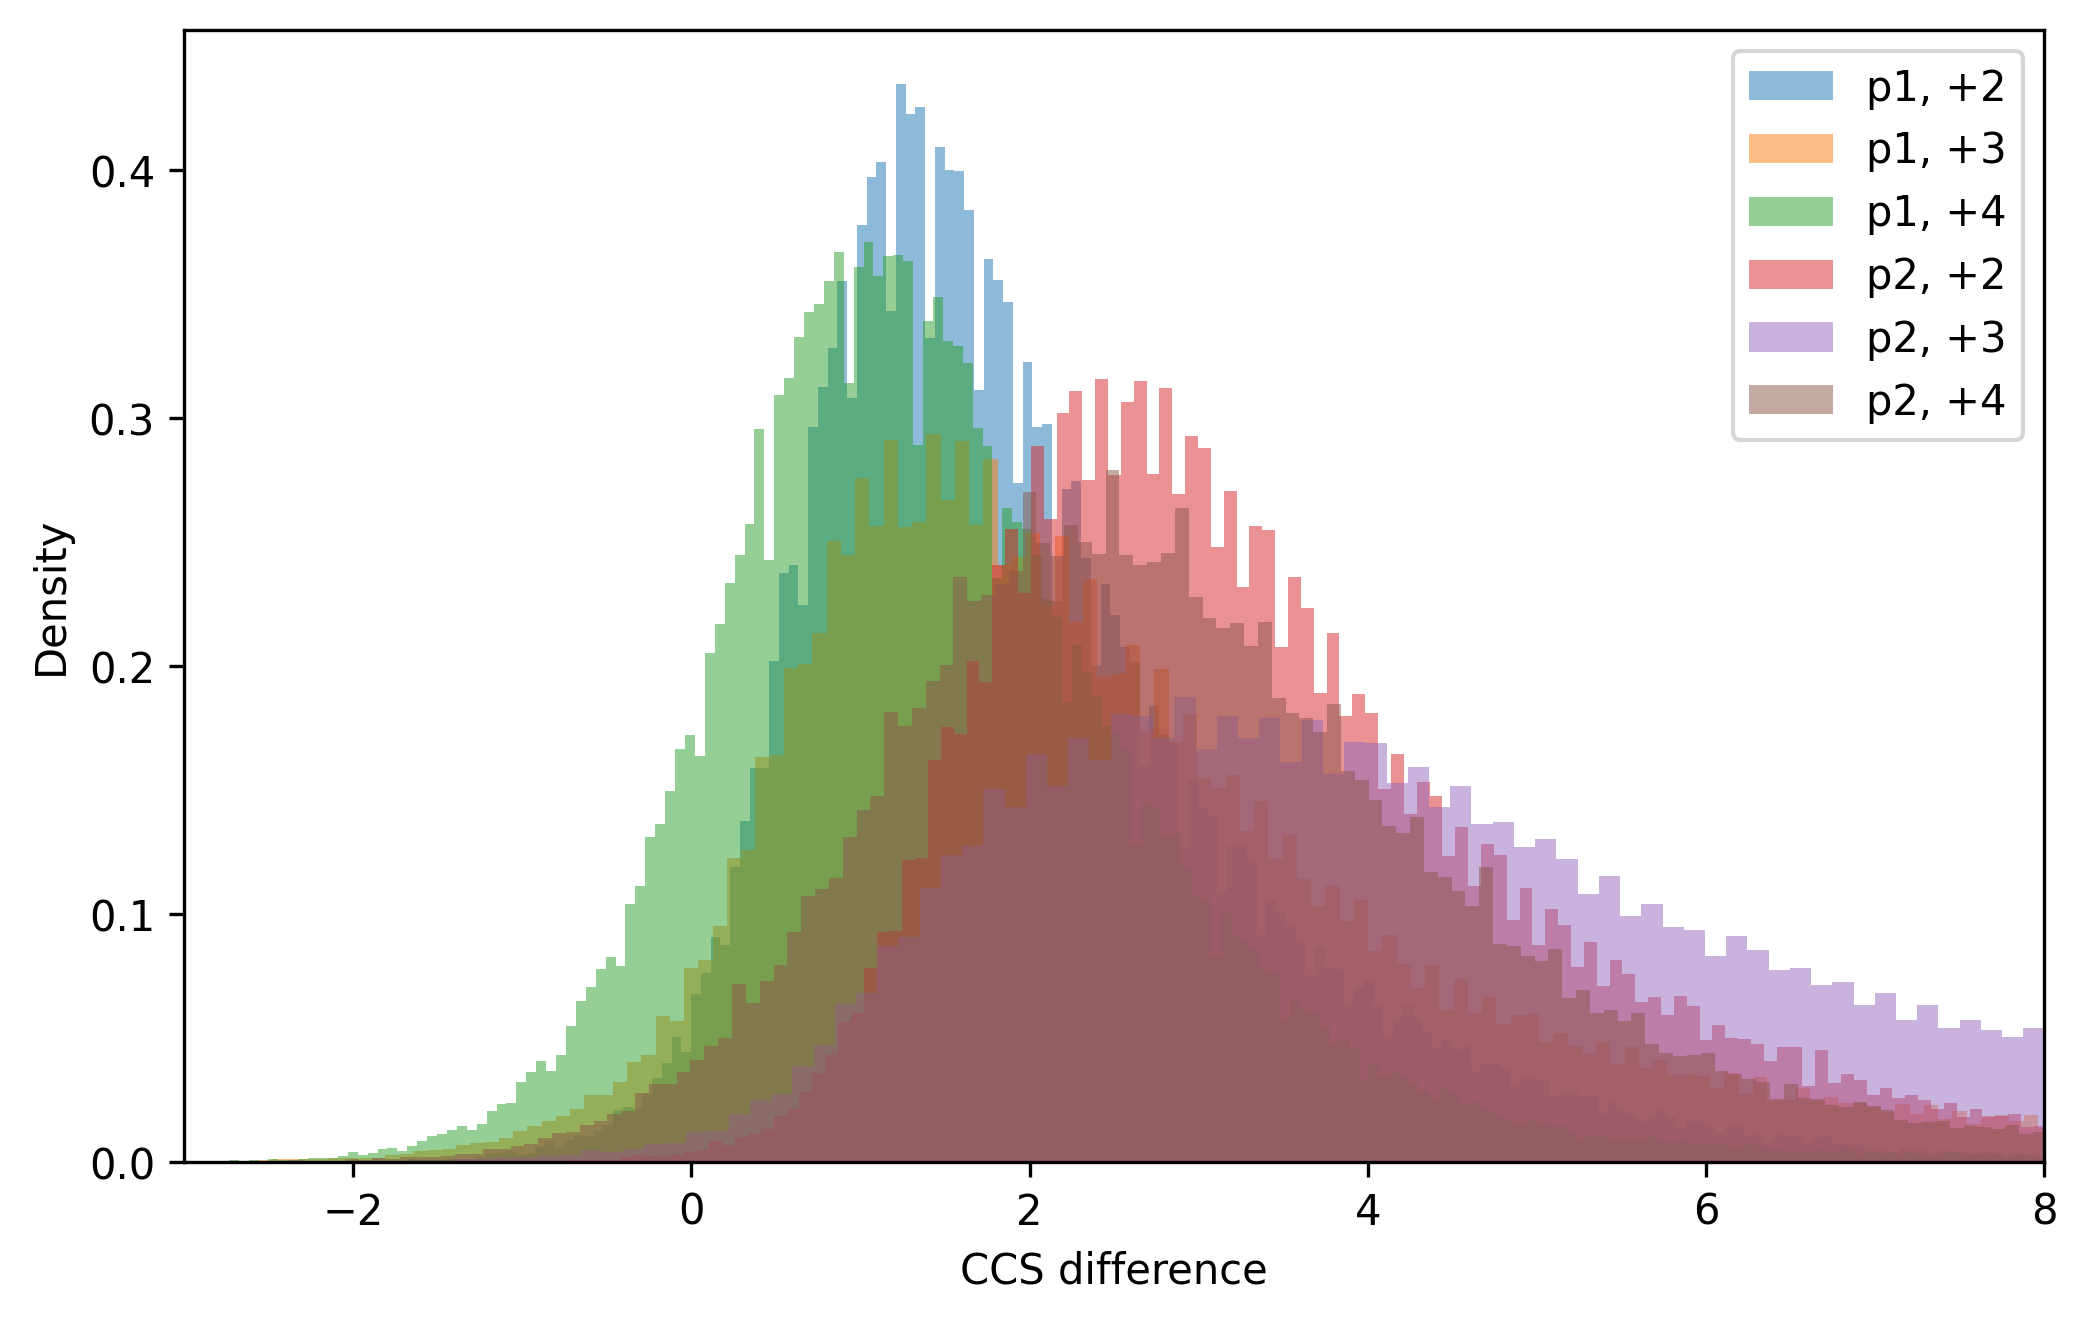

In [20]:
plt.figure(figsize=(8, 5), dpi=300)

for i, c in enumerate(range(2, 5)):
    tmp = data[data.charge == c]
    
    print(np.median(tmp.ccs_diff))
    
    if c == 2:
        plt.hist(tmp.ccs_diff, bins='auto', density=True, alpha=0.5, label='p1, +2')
    elif c == 3:
        plt.hist(tmp.ccs_diff, bins='auto', density=True, alpha=0.5, label='p1, +3')
    else:
        plt.hist(tmp.ccs_diff, bins='auto', density=True, alpha=0.5, label='p1, +4')

for i, c in enumerate(range(2, 5)):
    tmp = data[data.charge == c]
    
    print(np.median(tmp.ccs_diff_phos_twice))
    
    if c == 2:
        plt.hist(tmp.ccs_diff_phos_twice, bins='auto', density=True, alpha=0.5, label='p2, +2')
    elif c == 3:
        plt.hist(tmp.ccs_diff_phos_twice, bins='auto', density=True, alpha=0.5, label='p2, +3')
    else:
        plt.hist(tmp.ccs_diff_phos_twice, bins='auto', density=True, alpha=0.5, label='p2, +4')

plt.xlim(-3, 8)
plt.ylabel('Density')
plt.xlabel('CCS difference')
plt.legend()
plt.show()

In [24]:
p1 = np.round(np.mean([1.70, 2.09, 1.31]), 1)
p2 = np.round(np.mean([3.07, 4.03, 2.75]), 1)

print(p1, p2)

1.7 3.3
